In [15]:
import pandas as pd
import numpy as np
import matplotlib
import seaborn as sns
import pystan
import fbprophet 
import plotly 



#built-in 
import datetime

print('pandas ==',pd.__version__)
print('numpy ==',np.__version__)
print('matplotlib ==',matplotlib.__version__)
print('seaborn ==',sns.__version__)
print('plotly ==', plotly.__version__)
print('pystan ==',pystan.__version__)
print('fbprophet ==',fbprophet.__version__)

pandas == 1.2.2
numpy == 1.19.2
matplotlib == 3.3.4
seaborn == 0.11.1
plotly == 4.11.0
pystan == 2.19.1.1
fbprophet == 0.7.1


# Funções

In [16]:
# =======================================================================================
## FUNÇÕES PARA A IMPORTAÇÃO DOS DADOS E TRANSFORMAR DATAS

def converte_variaveis_em_datas(dataframe):
    for variavel in dataframe.columns:
        if 'DATA' in variavel:
            try:
                dataframe[variavel] = pd.to_datetime(dataframe[variavel], format='%d/%m/%Y')
            
            except:
                print(f'Variável "{variavel}" contém um erro e conversão/formatação')
                pass
        else:
            pass 
    return dataframe


def tira_variaveis_IBGE(dataframe):
    dataframe = dataframe.drop(['IBGE_RES_PR','IBGE_ATEND_PR'], axis='columns')
    return dataframe


def cria_variavel_caso_confirmado_no_dia(dataframe):
    dataframe['CASO_CONFIRMADO_NO_DIA'] = 1
    return dataframe


def replace_nas_variaveis_obito_status(dataframe):

    dataframe['OBITO'] = dataframe['OBITO'].replace('SIM','Sim')
    dataframe['OBITO'] = dataframe['OBITO'].replace('Não','Nao')

    dataframe['OBITO'] = dataframe['OBITO'].replace('Sim',1)
    dataframe['OBITO'] = dataframe['OBITO'].replace('Nao',0)

    dataframe['STATUS'] = dataframe['STATUS'].replace('Recuperado','recuperado')
    dataframe['STATUS'] = dataframe['STATUS'].replace('recuperado', 1)
    dataframe['STATUS'] = dataframe['STATUS'].replace('nan', 0)

    return dataframe
    

def pre_processamento(dataframe):
    dataframe = converte_variaveis_em_datas(dataframe)
    dataframe = tira_variaveis_IBGE(dataframe)
    dataframe = cria_variavel_caso_confirmado_no_dia(dataframe)
    dataframe = replace_nas_variaveis_obito_status(dataframe)
    dataframe = dataframe.set_index('DATA_CONFIRMACAO_DIVULGACAO')
    dataframe = dataframe.sort_index()
    return dataframe

def baixa_base_de_dados_casos_gerais(ano,mes,dia):
    """
    Esta função baixa a base de dados disponível no ano, mes e dia.
    retorna um dataframe do pandas com os dados disponpiveis.
    """
    data = datetime.date(ano, mes, dia)
    ano = str(data.year)

    if mes != 10 and mes != 11 and mes != 12:
        mes = '0'+str(data.month)
    else:
        mes = str(data.month)

    if dia in [1,2,3,4,6,7,8,9]:
        dia = '0'+str(data.day)

    ano_mes = ano+'-'+mes

    if ano == '2020':
        arquivo = f'INFORME_EPIDEMIOLOGICO_{dia}_{mes}_GERAL.csv'
    elif ano == '2021':
        arquivo = f'informe_epidemiologico_{dia}_{mes}_{ano}_geral.csv'
    # Podem acontecer as seguintes variações no site do estado:
    # informe_epidemiologico_{dia}_{mes}_{ano}_geral.csv
    # informe_epidemiologico_{dia}_{mes}_geral.csv
    # INFORME_EPIDEMIOLOGICO_{dia}_{mes}_GERAL.csv



    dominio = 'https://www.saude.pr.gov.br'
    caminho = f'/sites/default/arquivos_restritos/files/documento/{ano_mes}/'
    try:

        url = dominio+caminho+arquivo
        base_de_dados = pd.read_csv(url, sep=';')
        base_de_dados = pre_processamento(base_de_dados)
        
    
    except:
        raise Exception('Não Tem dados disponíveis neste dia.')

    return base_de_dados

# =======================================================================================
## FUNÇÕES PARA SELEÇÃO 

def seleciona_media_movel(dataframe):

    if 'MUN_ATENDIMENTO' in dataframe.columns and 'DATA_CONFIRMACAO_DIVULGACAO' in dataframe.columns:
        dataframe = dataframe.groupby(['MUN_ATENDIMENTO','DATA_CONFIRMACAO_DIVULGACAO'])[['CASO_CONFIRMADO_NO_DIA','OBITO']].sum().rolling(15).mean()[15:]
        return dataframe
    else:
        raise Exception('')




# Importando os Dados 

In [17]:
hoje = datetime.date.today()
informe_covid = baixa_base_de_dados_casos_gerais(hoje.year, hoje.month, hoje.day - 1)

Variável "DATA_INICIO_SINTOMAS" contém um erro e conversão/formatação


In [18]:
informe_covid

,SEXO,IDADE_ORIGINAL,MUN_RESIDENCIA,MUN_ATENDIMENTO,LABORATORIO,DATA_DIAGNOSTICO,DATA_INICIO_SINTOMAS,OBITO,DATA_OBITO,DATA_OBITO_DIVULGACAO,STATUS,DATA_RECUPERADO_DIVULGACAO,FONTE_DADO_RECUPERADO,CASO_CONFIRMADO_NO_DIA
DATA_CONFIRMACAO_DIVULGACAO,,,,,,,,,,,,,,
2020-03-12,F,26,CURITIBA,CURITIBA,Genoprimer,2020-03-16,11/03/2020,0.0,NaT,NaT,1.0,NaT,NaN,1
2020-03-12,M,43,CURITIBA,CURITIBA,LACEN,2020-03-12,07/03/2020,0.0,NaT,NaT,1.0,NaT,NaN,1
2020-03-12,M,15,CURITIBA,CURITIBA,LACEN,2020-03-12,08/03/2020,0.0,NaT,NaT,1.0,NaT,NaN,1
2020-03-12,F,26,CURITIBA,CURITIBA,Genoprimer,2020-03-18,15/03/2020,0.0,NaT,NaT,1.0,NaT,NaN,1
2020-03-12,M,28,SAO PAULO/SP,CURITIBA,Genoprimer,2020-03-16,NaN,0.0,NaT,NaT,1.0,2020-08-05,SMS,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-09,M,57,ARAPONGAS,ARAPONGAS,Teste Rápido Antígeno (Imunocromatografia),2021-03-08,NaN,NaN,NaT,NaT,NaN,NaT,NaN,1
2021-03-09,M,36,ARAUCARIA,ARAUCARIA,"COVID-19, Biologia Molecular",2021-03-08,05/03/2021,NaN,NaT,NaT,NaN,NaT,NaN,1
2021-03-09,M,68,FOZ DO IGUACU,FOZ DO IGUACU,"COVID-19, Biologia Molecular",2021-03-01,24/02/2021,NaN,NaT,NaT,NaN,NaT,NaN,1


In [19]:
def seleciona_cidade(cidade, dataframe):
    """
    Esta função retona todos os registros
    cujo o atendimento ocorreu na cidade 
    passada como parâmetro.
    Retorna um dataframe.
    """
    dados_cidade = dataframe.query(f'MUN_ATENDIMENTO == "{cidade.upper()}"')
    return dados_cidade.reset_index()



In [20]:
move_average_15_por_cidade = informe_covid.groupby(['MUN_ATENDIMENTO','DATA_CONFIRMACAO_DIVULGACAO'])[['CASO_CONFIRMADO_NO_DIA','OBITO']].sum().rolling(14).mean()[14:].round()
casos_por_cidade = informe_covid.groupby(['MUN_ATENDIMENTO','DATA_CONFIRMACAO_DIVULGACAO'])[['CASO_CONFIRMADO_NO_DIA','OBITO']].sum().round()

In [21]:
move_average_15_por_cidade

CASO_CONFIRMADO_NO_DIA  OBITO
MUN_ATENDIMENTO DATA_CONFIRMACAO_DIVULGACAO                               
ABATIA          2020-07-01                                      2.0    0.0
                2020-07-02                                      2.0    0.0
                2020-07-03                                      2.0    0.0
                2020-07-07                                      3.0    0.0
                2020-07-08                                      3.0    0.0
...                                                             ...    ...
XAMBRE          2021-02-26                                      2.0    0.0
                2021-02-27                                      2.0    0.0
                2021-03-02                                      2.0    0.0
                2021-03-04                                      2.0    0.0
                2021-03-07                                      2.0    0.0

[50959 rows x 2 columns]

In [22]:
casos_por_cidade

CASO_CONFIRMADO_NO_DIA  OBITO
MUN_ATENDIMENTO DATA_CONFIRMACAO_DIVULGACAO                               
ABATIA          2020-05-08                                        1    0.0
                2020-05-31                                        1    0.0
                2020-06-05                                        4    0.0
                2020-06-08                                        1    0.0
                2020-06-11                                        1    0.0
...                                                             ...    ...
XAMBRE          2021-02-26                                        3    0.0
                2021-02-27                                        1    0.0
                2021-03-02                                        1    0.0
                2021-03-04                                        2    0.0
                2021-03-07                                        4    0.0

[50973 rows x 2 columns]

In [28]:
def atualiza_dados_diarios():
    hoje = datetime.date.today()
    informe_covid = baixa_base_de_dados_casos_gerais(hoje.year, hoje.month, hoje.day - 1)

    move_average_15_por_cidade = informe_covid.groupby(['MUN_ATENDIMENTO','DATA_CONFIRMACAO_DIVULGACAO'])[['CASO_CONFIRMADO_NO_DIA','OBITO']].sum().rolling(14).mean()[14:].round()
    move_average_15_por_cidade.to_csv('../dados_recentes/cidades_mm15.csv', sep=';')

    casos_por_cidade = informe_covid.groupby(['MUN_ATENDIMENTO','DATA_CONFIRMACAO_DIVULGACAO'])[['CASO_CONFIRMADO_NO_DIA','OBITO']].sum().round()
    casos_por_cidade.to_csv('../dados_recentes/casos_por_cidade.csv', sep=';')    



# Dados de Internações

In [174]:
uri_internacoes = 'https://raw.githubusercontent.com/ConradBitt/covid_parana/main/dados_recentes/INTERNACOES_TRATAMENTO%20DE%20INFEC%C3%87%C3%83O%20PELO_CORONAVIRUS_COVID%2019.csv'

In [179]:
internacoes = pd.read_csv(uri_internacoes,sep=';',
 skiprows = 4,
 skipfooter=14,
 thousands=',',
 engine='python', encoding='iso-8859-1')

In [180]:
internacoes

,Município,2020/Mar,2020/Abr,2020/Mai,2020/Jun,2020/Jul,2020/Ago,2020/Set,2020/Out,2020/Nov,2020/Dez,2021/Jan,Total
0,410045 Altamira do Paraná,-,-,-,-,-,2,-,1,-,-,-,3
1,410060 Alto Paraná,-,-,-,-,-,-,-,-,-,-,1,1
2,410100 Ampére,-,-,-,-,2,3,6,6,6,6,13,42
3,410140 Apucarana,-,12,27,29,69,69,60,38,40,41,3,388
4,410150 Arapongas,-,7,26,43,118,85,60,14,19,110,84,566
...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,412800 Ubiratã,-,-,-,1,-,-,5,6,8,26,17,63
124,412810 Umuarama,-,2,7,29,89,82,56,30,55,137,49,536
125,412820 União da Vitória,-,-,3,7,13,11,7,3,20,26,6,96
126,412855 Vera Cruz do Oeste,-,-,-,4,3,-,-,-,1,3,-,11


In [183]:
def pre_processamento_dados_internacoes(dataframe):
    from unidecode import unidecode
    municipios = []
    for municipio in dataframe['Município']:
        municipios.append(unidecode(municipio[7:]).upper())

    dataframe['Município'] = municipios
    dataframe.drop('Total',axis='columns')
    dataframe = dataframe.T.iloc[:-1]
    index = [
        'MUN_ATENDIMENTO', '2020-03', '2020-04',
        '2020-05', '2020-06', '2020-07',
        '2020-08', '2020-09', '2020-10', 
        '2020-11', '2020-12', '2021-01'
        ]

    dataframe.index = index
    dataframe = dataframe.T
    dataframe = dataframe.set_index('MUN_ATENDIMENTO')
    dataframe = dataframe.replace('-',0).astype(int)
    dataframe.columns = pd.to_datetime(dataframe.columns)
    return dataframe.T



In [ ]:
def pre_processamento_dados_internacoes(dataframe):
    from unidecode import unidecode
    municipios = []
    for municipio in dataframe['Município']:
        municipios.append(unidecode(municipio[7:]).upper())

    dataframe['Município'] = municipios
    dataframe.drop('Total',axis='columns')
    dataframe = dataframe.T.iloc[:-1]
    index = [
        'MUN_ATENDIMENTO', '2020-03', '2020-04',
        '2020-05', '2020-06', '2020-07',
        '2020-08', '2020-09', '2020-10', 
        '2020-11', '2020-12', '2021-01'
        ]

    dataframe.index = index
    dataframe = dataframe.T
    dataframe = dataframe.set_index('MUN_ATENDIMENTO')
    dataframe = dataframe.replace('-',0).astype(int)
    dataframe.columns = pd.to_datetime(dataframe.columns)
    return dataframe.T

def carrega_internacoes():
    uri_internacoes = 'https://raw.githubusercontent.com/ConradBitt/covid_parana/main/dados_recentes/INTERNACOES_TRATAMENTO%20DE%20INFEC%C3%87%C3%83O%20PELO_CORONAVIRUS_COVID%2019.csv'
    internacoes = pd.read_csv(uri_internacoes,sep=';',skiprows = 4,skipfooter=14,thousands=',', engine='python', encoding='iso-8859-1')
    internacoes = pre_processamento_dados_internacoes(internacoes)

    return internacoes

In [184]:
internacoes = pre_processamento_dados_internacoes(internacoes)


<AxesSubplot:>

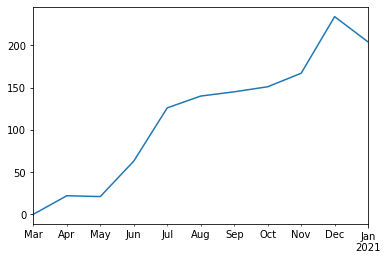

In [186]:
internacoes['PONTA GROSSA'].plot()